![Picture title](image-20230117-232434.png)

# NYC Traffic Danger (2021)

By Mary Nwangwu, Gail Batutis, Mallory Sico, and Annabelle Huether

In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import folium
from folium import plugins
from folium.plugins import HeatMap
import geopandas as gpd
from sklearn.cluster import DBSCAN
import seaborn as sns
import datetime as dt

# Question 1: What were the most dangerous areas in NYC in 2021?

In [2]:
all_data = pd.read_csv(r"clean_all_with_zips_buroughs_final_version.csv")
all_data = all_data[(all_data.iloc[:,5] > 0)] #dropped a couple hundred rows with zero lat/long values
all_data.shape

(100845, 27)

In [3]:
all_data

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,3,2021-09-11,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"40.667202, -73.8665",0.0,0.0,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
1,4,2021-12-14,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"40.683304, -73.917274",0.0,0.0,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN
2,6,2021-12-14,17:05,BROOKLYN,11249.0,40.709183,-73.956825,"40.709183, -73.956825",0.0,0.0,...,Unspecified,NaN,NaN,NaN,4486555,Sedan,Tractor Truck Diesel,NaN,NaN,NaN
3,7,2021-12-14,8:17,BRONX,10475.0,40.868160,-73.831480,"40.86816, -73.83148",2.0,0.0,...,Unspecified,NaN,NaN,NaN,4486660,Sedan,Sedan,NaN,NaN,NaN
4,8,2021-12-14,21:10,BROOKLYN,11207.0,40.671720,-73.897100,"40.67172, -73.8971",0.0,0.0,...,Unspecified,NaN,NaN,NaN,4487074,Sedan,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101483,186224,2021-01-17,22:50,BROOKLYN,11210.0,40.634300,-73.942710,"40.6343, -73.94271",1.0,0.0,...,Headlights Defective,NaN,NaN,NaN,4384827,Sedan,Bike,NaN,NaN,NaN
101484,1925266,2021-09-02,13:30,QUEENS,11428.0,40.715760,-73.746550,"40.71576, -73.74655",4.0,0.0,...,Unspecified,Unspecified,NaN,NaN,4562260,Sedan,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN
101485,1931659,2021-11-27,7:15,MANHATTAN,10003.0,40.725155,-73.990910,"40.725155, -73.99091",0.0,0.0,...,NaN,NaN,NaN,NaN,4568379,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
101486,1933449,2021-10-03,16:42,MANHATTAN,10035.0,40.804375,-73.937420,"40.804375, -73.93742",0.0,0.0,...,Passing or Lane Usage Improper,NaN,NaN,NaN,4569870,Sedan,Box Truck,NaN,NaN,NaN


In [4]:
#Create folium map centered in NYC
m = folium.Map(location=[40.75,-74.125])

#ask for input for map design and make everything lower case
val = input('Enter one of the following to see a map of the death: \n all persons \n pedestrians \n cyclists \n motorists \n' )
val = val.lower()

#convert text to column number
if val == 'all persons':
    val = 9
elif val == 'pedestrians':
    val = 11
elif val == 'cyclists':
    val = 13
elif val == 'motorists':
    val = 15
else:
    print("unacceptable entry, please try again")

#create death database based on the column number above
death = all_data[all_data.iloc[:,val] > 0]
death

#iteratively create markers in folium map, with lat/long and contributing factor vehicle as popup
for i in range(len(death['ZIP CODE'])):
    folium.Marker(
        location=[death['LATITUDE'].iloc[i],death['LONGITUDE'].iloc[i]],
        popup=str(death['CONTRIBUTING FACTOR VEHICLE 1'].iloc[i]),
        icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(m)
    
m

Enter one of the following to see a map of the death: 
 all persons 
 pedestrians 
 cyclists 
 motorists 
motorists


In [5]:
#create data for heat map - all injuries (injury column above 0)
heat_data = all_data[all_data.iloc[:,8] > 0]
heat_data = [[row['LATITUDE'],row['LONGITUDE']] for index, row in heat_data.iterrows()]

#create heat map, centered on NYC
heat_map = folium.Map(location=[40.75,-74.125]) 
HeatMap(heat_data, min_opacity=0.2,blur = 15, radius = 15).add_to(heat_map)

heat_map

In [6]:
#Group all the data by zip code, summing all the numerical columns, and cutting down to the only ones we need
all_sum_zip = all_data.groupby(['ZIP CODE']).sum()
all_sum_zip = all_sum_zip.iloc[:,0:11]

#make the index into a column called ZIPCODE, and make it a string and cut off the ".0" on the end
all_sum_zip['ZIPCODE'] = all_sum_zip.index.astype(str)
all_sum_zip['ZIPCODE'] = [x[:-2] for x in all_sum_zip['ZIPCODE']]

all_sum_zip

,Unnamed: 0,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,ZIPCODE
ZIP CODE,,,,,,,,,,,,
10000.0,3525092,1875.220237,-3402.763285,13.0,0.0,3,0,4,0,6,0,10000
10001.0,40548153,20863.887285,-37885.548573,218.0,1.0,56,1,57,0,98,0,10001
10002.0,55406587,31189.534430,-56674.919307,385.0,2.0,90,1,113,1,157,0,10002
10003.0,31367088,15681.707322,-28485.790378,180.0,0.0,51,0,63,0,58,0,10003
10004.0,5340749,2564.381990,-4662.801210,12.0,0.0,6,0,2,0,4,0,10004
...,...,...,...,...,...,...,...,...,...,...,...,...
11693.0,10201475,5602.098773,-10186.592509,62.0,1.0,9,0,9,0,37,1,11693
11694.0,11135523,5681.320498,-10337.025490,52.0,0.0,12,0,5,0,33,0,11694
11695.0,26553,40.566185,-73.881966,0.0,0.0,0,0,0,0,0,0,11695


In [10]:
#read in the geojson file
df_places = gpd.read_file(r"zip_code_040114.geojson")
# https://data.beta.nyc/en/dataset/nyc-zip-code-tabulation-areas/resource/894e9162-871c-4552-a09c-c6915d8783fb
df_places

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,10310,0,Staten Island,25003.0,5.346328e+07,NY,Richmond,36,085,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.12065 40.64104, -74.12057 40.641..."
259,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.84076 40.62536, -73.84306 40.627..."
260,11249,0,Brooklyn,28481.0,1.777221e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95805 40.72442, -73.95772 40.724..."
261,10162,1,New York,0.0,2.103489e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95133 40.76931, -73.95165 40.769..."


In [11]:
#merge on the geojson file, on the column ZIPCODE in each
df_merged = pd.merge(df_places,all_sum_zip, how = "left", on='ZIPCODE')
df_merged

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,17572.286210,-31880.820132,225.0,3.0,18.0,0.0,6.0,0.0,199.0,3.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,41444.206109,-75340.142457,545.0,3.0,96.0,0.0,40.0,0.0,380.0,3.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,...,60221.512010,-109466.461986,768.0,3.0,134.0,2.0,41.0,0.0,567.0,1.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,...,26309.244952,-47848.599911,363.0,1.0,52.0,1.0,33.0,0.0,260.0,0.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,...,25605.027631,-46605.321789,328.0,1.0,60.0,0.0,53.0,0.0,202.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,10310,0,Staten Island,25003.0,5.346328e+07,NY,Richmond,36,085,http://www.usps.com/,...,11701.371701,-21345.784418,118.0,0.0,8.0,0.0,8.0,0.0,99.0,0.0
259,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,Kings,36,047,http://www.usps.com/,...,5602.098773,-10186.592509,62.0,1.0,9.0,0.0,9.0,0.0,37.0,1.0
260,11249,0,Brooklyn,28481.0,1.777221e+07,NY,Kings,36,047,http://www.usps.com/,...,19337.518678,-35131.851313,187.0,0.0,36.0,0.0,42.0,0.0,98.0,0.0
261,10162,1,New York,0.0,2.103489e+04,NY,New York,36,061,http://www.usps.com/,...,5259.206783,-9539.368996,77.0,0.0,0.0,0.0,3.0,0.0,74.0,0.0


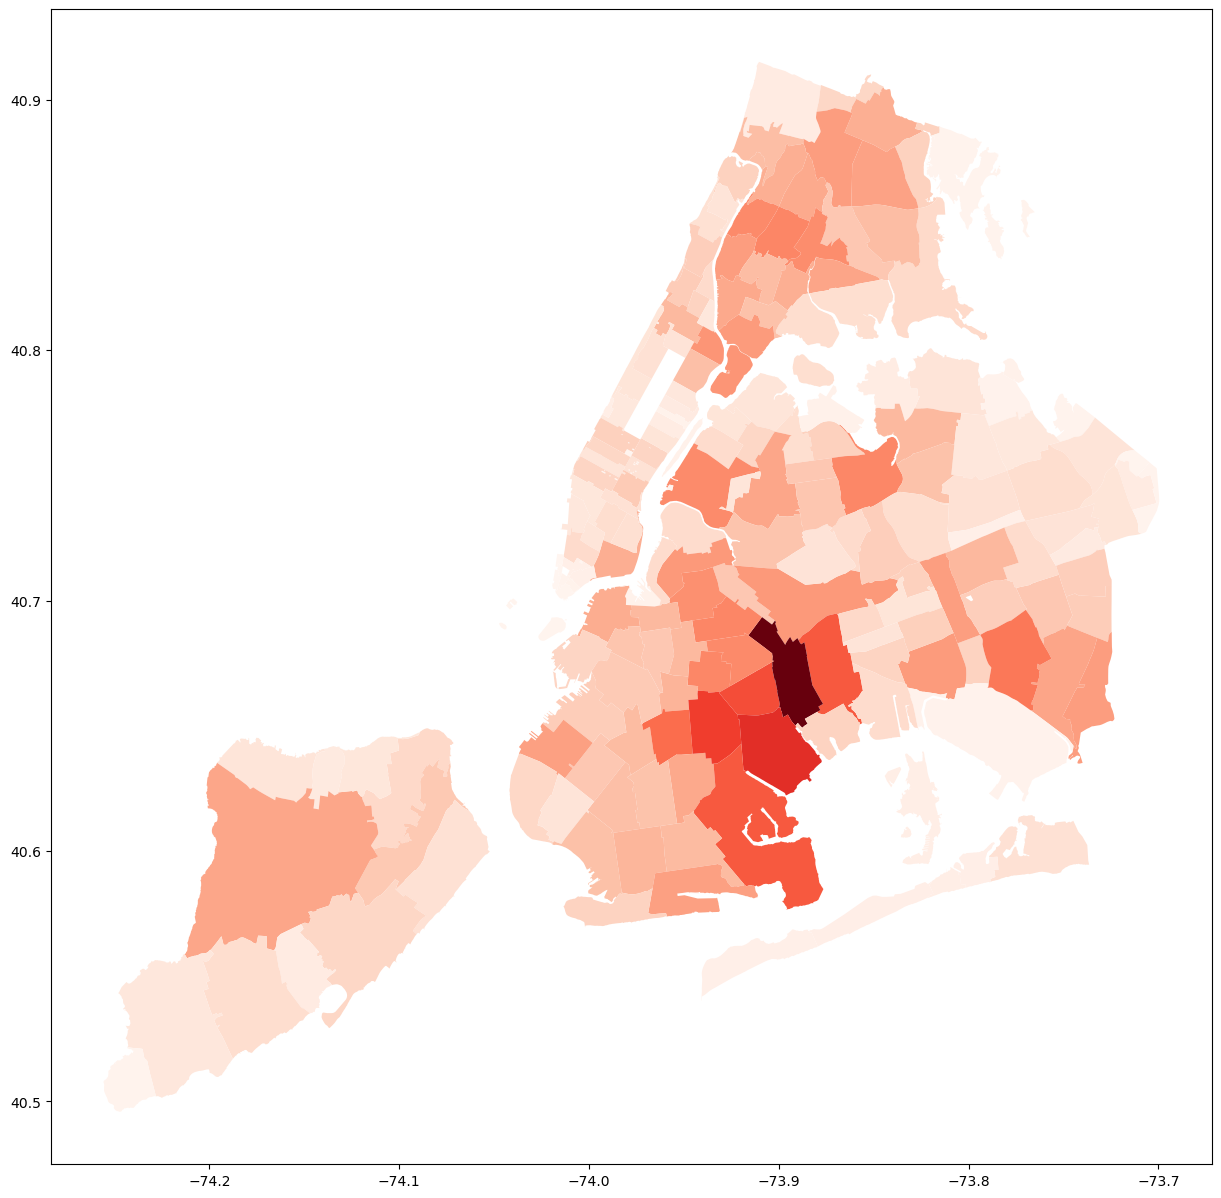

In [12]:
#plot the geojson file with a color map based on values in the Persons Injured column
f, ax = plt.subplots(1, figsize=(15, 15))
ax = df_merged.plot(column='NUMBER OF PERSONS INJURED', cmap='Reds' ,ax=ax)
plt.show()

In [15]:
#asks for zipcode input for DBSCAN calculation, which condition the resulting dataset
zipcode = input("Enter zip code: ")
prep = (all_data[(all_data['ZIP CODE']==float(zipcode))])
points = (prep.iloc[:,5:7])

#DBSCAN with radius .0001 (36 ft) and 5 collisions per cluster
clustering = DBSCAN(eps=0.0001, min_samples=5).fit(points)

Enter zip code: 11206


In [16]:
#output of DBSCAN
clustering.labels_

array([ 0, -1, -1, ..., -1, -1, -1])

In [17]:
#create masks of the above labels in true and false, for graphing
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_
xy = points

#count number of clusters and number of noise points
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

#print number of clusters and number of noise points
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 61
Estimated number of noise points: 640


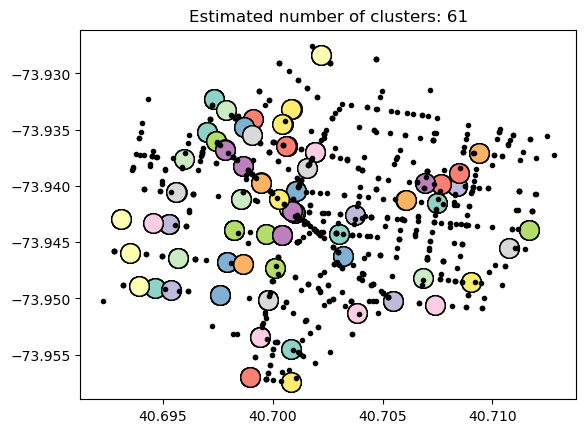

In [20]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Set3(each) for each in np.linspace(0, 1, len(unique_labels))]

#iterate through graphing clusters and noise, with varying colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k
    #plot noise points
    xy = points[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=3,
    )
    #plot cluster points
    ab = points[class_member_mask & core_samples_mask]
    plt.plot(
        ab.iloc[:,0],
        ab.iloc[:,1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )


#name plot and show it
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [21]:
#get cluster points only, and center folium map on the first item on the resulting list
cd = points[~class_member_mask & core_samples_mask]
n = folium.Map(location=[cd.iloc[0,0],cd.iloc[0,1]], max_zoom=18, min_zoom = 14.5)

#create and iteratively place cluster markers on folium map
for i in range(len(cd)):
    folium.Marker(
        location=[cd.iloc[i,0],cd.iloc[i,1]],
        icon=folium.Icon(color="red",icon="fa-solid fa-circle-exclamation"), 
    ).add_to(n)

n

# Question 2: Which areas had the most bike accidents in NYC in 2021?

In [3]:
#Pull in all bike data from cleaned csv file
bike_df = pd.read_csv('clean_bike_final.csv')
bike_df

#Check names of all columns of bike dataframe
print(bike_df.columns)

#remove all columns that are old indices from previous iterations of the dataframes
del bike_df['Unnamed: 0.2'], bike_df['Unnamed: 0.1'], bike_df['Unnamed: 0']
bike_df

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CRASH DATE',
       'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'],
      dtype='object')


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF CYCLIST INJURED,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2021-12-14,12:54,BROOKLYN,11217.0,40.687534,-73.977500,"40.687534, -73.9775",1.0,0.0,1,...,Unspecified,NaN,NaN,NaN,4487052,Sedan,Bike,NaN,NaN,NaN
1,2021-12-14,16:25,MANHATTAN,10128.0,40.784615,-73.953964,"40.784615, -73.953964",1.0,0.0,1,...,Driver Inattention/Distraction,NaN,NaN,NaN,4486581,Van,Bike,NaN,NaN,NaN
2,2021-06-29,17:35,QUEENS,11691.0,40.609535,-73.753720,"40.609535, -73.75372",0.0,0.0,0,...,Unspecified,NaN,NaN,NaN,4456672,Station Wagon/Sport Utility Vehicle,E-Bike,NaN,NaN,NaN
3,2021-12-09,20:20,BROOKLYN,11223.0,40.592070,-73.962990,"40.59207, -73.96299",1.0,0.0,1,...,Unspecified,NaN,NaN,NaN,4485150,Bike,NaN,NaN,NaN,NaN
4,2021-12-09,23:15,BROOKLYN,11218.0,40.640835,-73.989670,"40.640835, -73.98967",1.0,0.0,1,...,Driver Inattention/Distraction,NaN,NaN,NaN,4485355,Sedan,Bike,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7242,2021-01-27,7:00,MANHATTAN,10029.0,40.786808,-73.945240,"40.786808, -73.94524",1.0,0.0,0,...,Unspecified,NaN,NaN,NaN,4387268,Tanker,E-Bike,NaN,NaN,NaN
7243,2021-01-22,22:45,BROOKLYN,11218.0,40.643574,-73.971660,"40.643574, -73.97166",2.0,0.0,1,...,Unspecified,Unspecified,NaN,NaN,4386418,Sedan,Sedan,Bike,NaN,NaN
7244,2021-02-06,0:30,MANHATTAN,10002.0,40.720980,-73.986960,"40.72098, -73.98696",1.0,0.0,1,...,Unspecified,NaN,NaN,NaN,4391810,Station Wagon/Sport Utility Vehicle,E-Bike,NaN,NaN,NaN
7245,2021-01-06,11:02,BROOKLYN,11226.0,40.650753,-73.950750,"40.650753, -73.95075",0.0,0.0,0,...,Unspecified,NaN,NaN,NaN,4382028,LIMO,Bike,NaN,NaN,NaN


In [4]:
#Bike data by burough
bikes_bur = bike_df.groupby('BOROUGH').sum()#.iloc[:, 3:7]
bikes_bur['TOTAL NUMBER OF CRASHES'] = bike_df['BOROUGH'].value_counts(sort=True)
#print(bikes_bur)

#Bike data by zip code
bikes_zip = bike_df.groupby('ZIP CODE').sum().iloc[:, 2:6]
bikes_zip['TOTAL NUMBER OF CRASHES'] = bike_df['ZIP CODE'].value_counts()
bikes_zip

#Group by Bourough and Zip Code
bikes_zips_and_bur = bike_df.groupby(by= ['BOROUGH', 'ZIP CODE'], group_keys=False)
bikes_zips_and_bur
bikes_zips_and_bur.sum()


LATITUDE    LONGITUDE  NUMBER OF PERSONS INJURED  \
BOROUGH       ZIP CODE                                                        
BRONX         10039.0     40.820515   -73.930695                        0.0   
              10451.0   2734.987427 -4952.697259                       56.0   
              10452.0   2450.235480 -4435.277444                       53.0   
              10453.0   2165.211400 -3917.282927                       48.0   
              10454.0   2530.155608 -4583.004304                       58.0   
...                             ...          ...                        ...   
STATEN ISLAND 10308.0    162.242892  -296.610540                        3.0   
              10309.0     81.024065  -148.462894                        1.0   
              10310.0    406.335874  -741.184760                       11.0   
              10312.0    324.465694  -593.457526                        8.0   
              10314.0    487.216361  -889.854454                       11.0   

                        NUMBER OF PERSONS KILLED  NUMBER OF CYCLIST INJURED  \
BOROUGH       ZIP CODE                                                        
BRONX         10039.0                        1.0                          0   
              10451.0                        1.0                         38   
              10452.0                        0.0                         33   
              10453.0                        0.0                         24   
              10454.0                        0.0                         37   
...                                          ...                        ...   
STATEN ISLAND 10308.0                        0.0                          3   
              10309.0                        0.0                          1   
              10310.0                        0.0                          8   
              10312.0                        0.0                          8   
              10314.0                        0.0                         11   

                        NUMBER OF CYCLIST KILLED  COLLISION_ID  
BOROUGH       ZIP CODE                                          
BRONX         10039.0                          0       4421887  
              10451.0                          1     297255434  
              10452.0                          0     266308107  
              10453.0                          0     235324047  
              10454.0                          0     275720733  
...                                          ...           ...  
STATEN ISLAND 10308.0                          0      17752557  
              10309.0                          0       8885793  
              10310.0                          0      44346278  
              10312.0                          0      35519680  
              10314.0                          0      53240318  

[202 rows x 7 columns]

,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,COLLISION_ID,TOTAL NUMBER OF CRASHES,TOTAL NUMBER OF COMMUTERS,PERCENT CYCLIST INJURED,PERCENT CYCLIST KILLED
BOROUGH,,,,,,,,,,,,
BRONX,9664292.0,37737.701942,-68277.315348,780.0,9.0,493,4,4101965048,924,2699,0.182660,0.001482
BROOKLYN,30829272.0,111744.556073,-203232.069512,2436.0,7.0,1780,5,12202758661,2748,23030,0.077290,0.000217
MANHATTAN,20651672.0,83983.742082,-152381.132380,1681.0,7.0,1341,5,9149090762,2060,20859,0.064289,0.000240
QUEENS,15969616.0,57389.129680,-104072.261728,1231.0,5.0,817,3,6259136872,1409,8257,0.098946,0.000363
STATEN ISLAND,1092457.0,4304.055845,-7857.142845,89.0,1.0,76,0,470432005,106,122,0.622951,0.000000


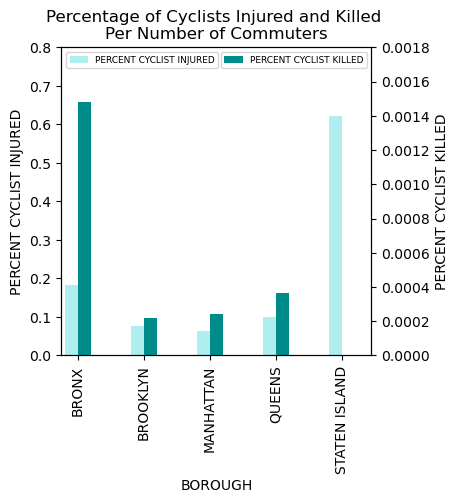

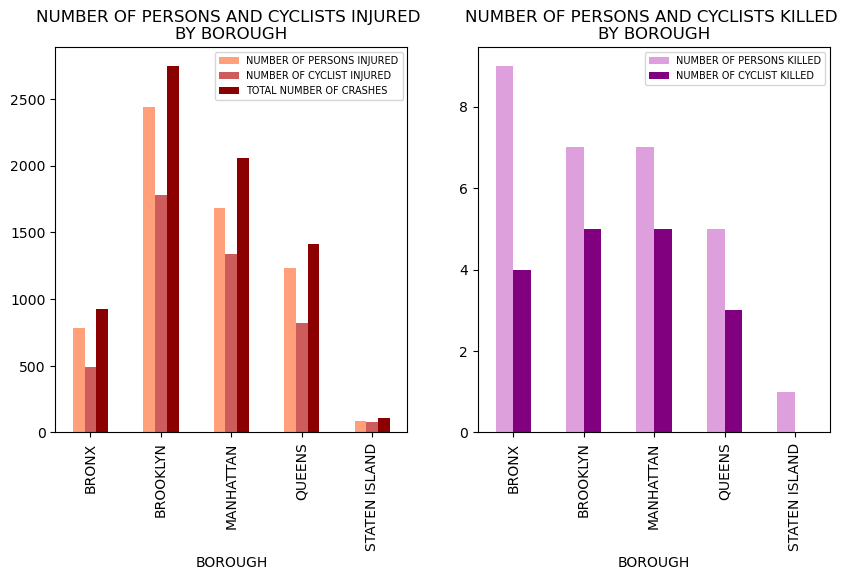

In [6]:
#Add total number of commuters to dataset

#Website with data on bike commuters by burough:
#https://www.nyc.gov/html/dot/html/bicyclists/cyclinginthecity.shtml
total_Number_of_Commuters = {'BRONX': 2699, 'BROOKLYN': 23030,'MANHATTAN': 20859, \
                             'QUEENS': 8257, 'STATEN ISLAND': 122}
bikes_bur['TOTAL NUMBER OF COMMUTERS'] = [2699, 23030, 20859, 8257, 122]

#Create columns for percentage of injuries and fatalities normalized by number of commuters
bikes_bur['PERCENT CYCLIST INJURED'] = bikes_bur['NUMBER OF CYCLIST INJURED'] / bikes_bur['TOTAL NUMBER OF COMMUTERS']
bikes_bur['PERCENT CYCLIST KILLED'] = bikes_bur['NUMBER OF CYCLIST KILLED'] / bikes_bur['TOTAL NUMBER OF COMMUTERS']

#Visualization of bike data normalized by number of commuters in each borough
#Note: This assumes that all injured people are distinct
#Note: Staten Island is likely not accurate because there is not as much data there
#Note: burough is not a great metric for determining safest location
fig= plt.figure(figsize= [4,4])
ax = fig.add_subplot(1, 1, 1) 
ax2 = ax.twinx()
width = 0.2
bikes_bur['PERCENT CYCLIST INJURED'].plot.bar(color='paleturquoise', ax=ax, width=width, position=1)
bikes_bur['PERCENT CYCLIST KILLED'].plot(kind='bar', color='darkcyan', ax=ax2, width=width, position=0)
ax.set(title = 'Percentage of Cyclists Injured and Killed \nPer Number of Commuters', ylabel = 'PERCENT CYCLIST INJURED', yticks = np.arange(0,0.9,0.1))
ax2.set(ylabel = 'PERCENT CYCLIST KILLED', yticks = np.arange(0,0.002,0.0002))
ax.legend(loc=2, fontsize = 6.5)
ax2.legend(loc=1, fontsize = 6.5)

#Create plots of number of total injuries and fatalities by persons and cyclists by burough
fig, axes = plt.subplots(nrows = 1, ncols = 2)
bikes_bur.iloc[:, [3, 5, 8]].plot.bar(ax=axes[0], figsize=(11,5), color = ['lightsalmon', 'indianred','darkred'])
bikes_bur.iloc[:, [4, 6]].plot.bar(ax=axes[1], figsize=(10,5), color = ['plum', 'purple'])
axes[0].legend(loc='upper right', fontsize=7)
axes[0].set(title = 'NUMBER OF PERSONS AND CYCLISTS INJURED \nBY BOROUGH', xlabel='BOROUGH')
axes[1].legend(loc='upper right', fontsize=7)
axes[1].set(title = 'NUMBER OF PERSONS AND CYCLISTS KILLED \nBY BOROUGH', xlabel='BOROUGH')
bikes_bur


In [12]:
#Loop of t-tests of injuries by burough 
#Brooklyn has statistically higher mean than all other buroughs

#Assumptions: all boroughs have same variance over zip codes
#Null-hypothesis: The first borough has a higher mean value of injuries in its distribution of zip codes
bur_names = bike_df['BOROUGH'].unique()
for i in range(len(bur_names)): 
    for j in range(len(bur_names)): 
        if j!=i: 
            t_stat, p_value = stats.ttest_ind(bike_df.groupby('BOROUGH').get_group(bur_name[i]).groupby('ZIP CODE').sum()['NUMBER OF PERSONS INJURED'],bike_df.groupby('BOROUGH').get_group(bur_name[j]).groupby('ZIP CODE').sum()['NUMBER OF PERSONS INJURED'], \
                                              alternative = 'greater')
            if p_value < 0.05: 
                print('p-Value: {:.2e}. {} has greater mean than {}'.format( p_value, bur_names[i], bur_names[j]))

p-Value: 1.50e-06. BROOKLYN has greater mean than MANHATTAN
p-Value: 1.44e-10. BROOKLYN has greater mean than QUEENS
p-Value: 1.52e-06. BROOKLYN has greater mean than STATEN ISLAND
p-Value: 8.42e-05. BROOKLYN has greater mean than BRONX
p-Value: 4.07e-02. MANHATTAN has greater mean than QUEENS
p-Value: 9.08e-03. MANHATTAN has greater mean than STATEN ISLAND
p-Value: 4.43e-02. QUEENS has greater mean than STATEN ISLAND
p-Value: 2.69e-02. BRONX has greater mean than QUEENS
p-Value: 2.16e-04. BRONX has greater mean than STATEN ISLAND


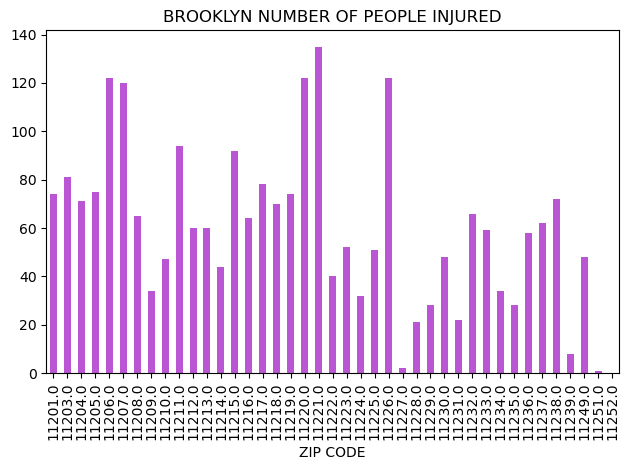

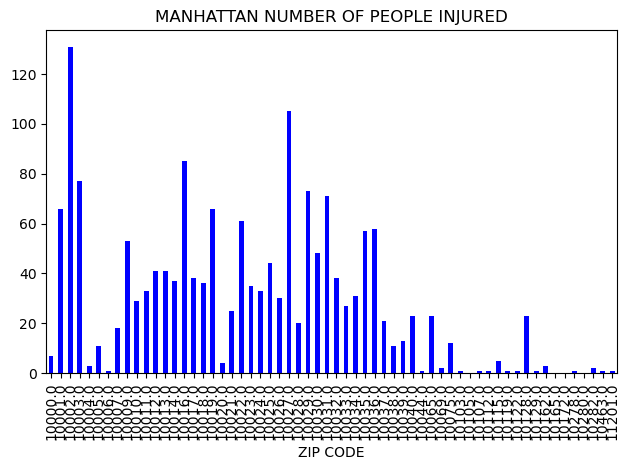

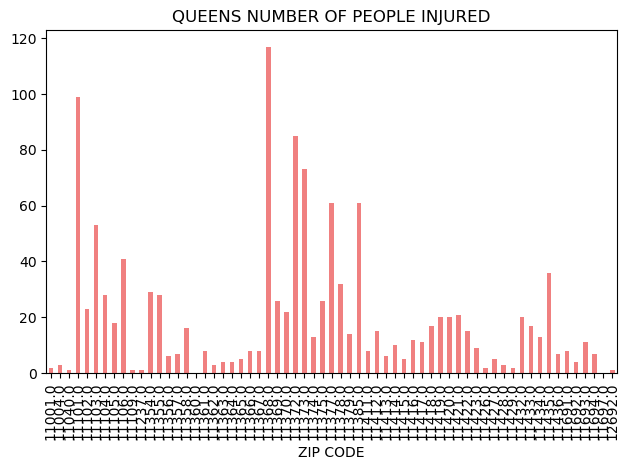

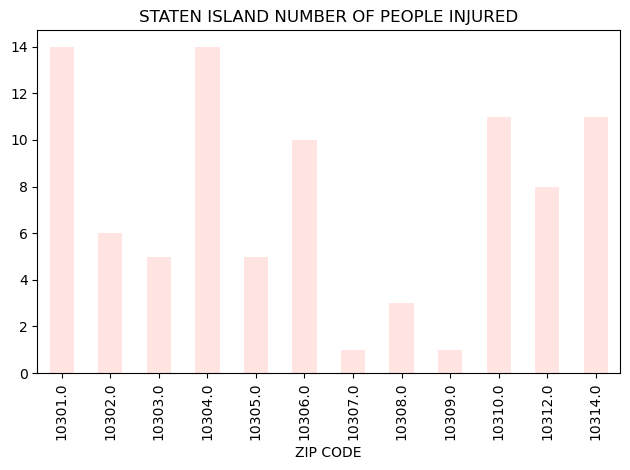

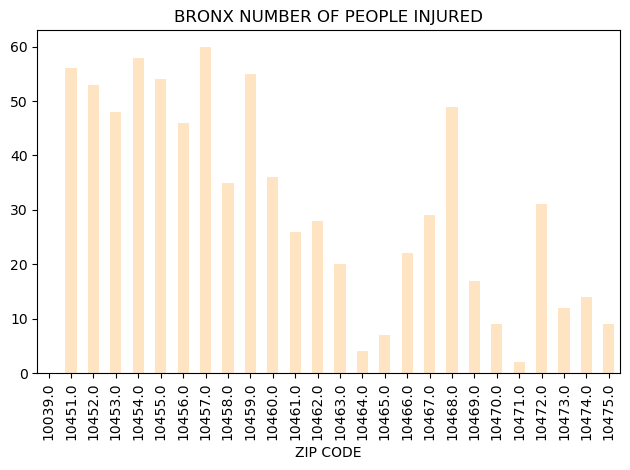

In [96]:
#Create bar plots of number of people injured in each burough separated by zipcode
def plot_borough(x, borough_name, color): 
    fig, ax = plt.subplots()
    ax = x.groupby('BOROUGH').get_group(borough_name).groupby('ZIP CODE').sum()['NUMBER OF PERSONS INJURED'].plot.bar(color = color)
    ax.set_title('{} NUMBER OF PEOPLE INJURED'.format(borough_name))
    fig.tight_layout()
        
color_array = ['mediumorchid', 'blue', 'lightcoral', 'mistyrose', 'bisque']
for bur in bike_df['BOROUGH'].unique(): 
    plot_borough(bike_df, bur, color_array[np.where(bike_df['BOROUGH'].unique()==bur)[0][0]])

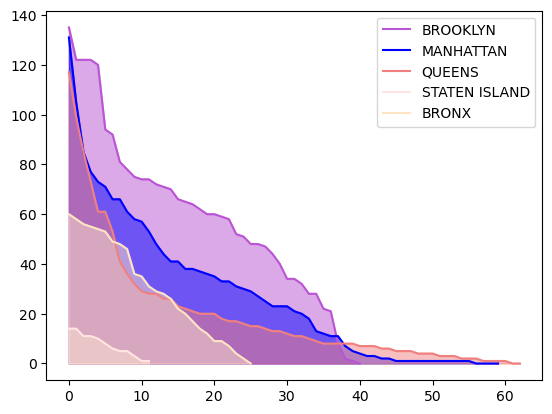

In [95]:
#Make line plot of data after sorting each borough by zip code in descending order
def bur_df_def(x, borough_name): 
    bur_df = bike_df.groupby('BOROUGH').get_group(borough_name).groupby('ZIP CODE').sum()['NUMBER OF PERSONS INJURED'].reset_index()
    bur_df = bur_df.sort_values(['NUMBER OF PERSONS INJURED'], ascending = False)
    bur_df = bur_df.reset_index()
    return np.array(bur_df.index), bur_df['NUMBER OF PERSONS INJURED']

color_array = ['mediumorchid', 'blue', 'lightcoral', 'mistyrose', 'bisque']
for bur in bike_df['BOROUGH'].unique():
    x, y = bur_df_def(bike_df, bur)
    plt.plot(x, y, label = bur, color = color_array[np.where(bike_df['BOROUGH'].unique()==bur)[0][0]])
    plt.fill_between(x, y, alpha = 0.5, color = color_array[np.where(bike_df['BOROUGH'].unique()==bur)[0][0]])
plt.legend()


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF CYCLIST INJURED,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2021-12-14,12:54,BROOKLYN,11217.0,40.687534,-73.977500,"40.687534, -73.9775",1.0,0.0,1,...,Unspecified,NaN,NaN,NaN,4487052,Sedan,Bike,NaN,NaN,NaN
1,2021-12-14,16:25,MANHATTAN,10128.0,40.784615,-73.953964,"40.784615, -73.953964",1.0,0.0,1,...,Driver Inattention/Distraction,NaN,NaN,NaN,4486581,Van,Bike,NaN,NaN,NaN
2,2021-06-29,17:35,QUEENS,11691.0,40.609535,-73.753720,"40.609535, -73.75372",0.0,0.0,0,...,Unspecified,NaN,NaN,NaN,4456672,Station Wagon/Sport Utility Vehicle,E-Bike,NaN,NaN,NaN
3,2021-12-09,20:20,BROOKLYN,11223.0,40.592070,-73.962990,"40.59207, -73.96299",1.0,0.0,1,...,Unspecified,NaN,NaN,NaN,4485150,Bike,NaN,NaN,NaN,NaN
4,2021-12-09,23:15,BROOKLYN,11218.0,40.640835,-73.989670,"40.640835, -73.98967",1.0,0.0,1,...,Driver Inattention/Distraction,NaN,NaN,NaN,4485355,Sedan,Bike,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7242,2021-01-27,7:00,MANHATTAN,10029.0,40.786808,-73.945240,"40.786808, -73.94524",1.0,0.0,0,...,Unspecified,NaN,NaN,NaN,4387268,Tanker,E-Bike,NaN,NaN,NaN
7243,2021-01-22,22:45,BROOKLYN,11218.0,40.643574,-73.971660,"40.643574, -73.97166",2.0,0.0,1,...,Unspecified,Unspecified,NaN,NaN,4386418,Sedan,Sedan,Bike,NaN,NaN
7244,2021-02-06,0:30,MANHATTAN,10002.0,40.720980,-73.986960,"40.72098, -73.98696",1.0,0.0,1,...,Unspecified,NaN,NaN,NaN,4391810,Station Wagon/Sport Utility Vehicle,E-Bike,NaN,NaN,NaN
7245,2021-01-06,11:02,BROOKLYN,11226.0,40.650753,-73.950750,"40.650753, -73.95075",0.0,0.0,0,...,Unspecified,NaN,NaN,NaN,4382028,LIMO,Bike,NaN,NaN,NaN


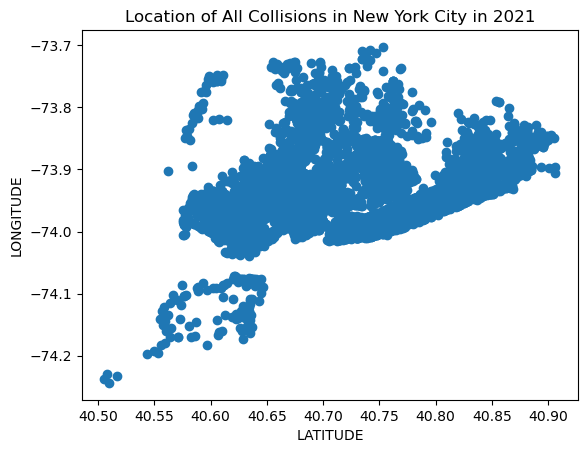

In [102]:
#Scatter Plot of all bike collision locations: 
plt.scatter(bike_df['LATITUDE'], bike_df['LONGITUDE'])
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')
plt.title('Location of All Collisions in New York City in 2021')

#2 dimensional numpy array of all coordinates
location = [[bike_df['LATITUDE'][i], bike_df['LONGITUDE'][i]] for i in range(len(bike_df))]
bike_df

In [97]:
#Map visualizations for bikes injuries for Staten Island

#2 dimensional numpy array of all coordinates in Staten Island
stat_isl = bike_df.groupby('BOROUGH').get_group('STATEN ISLAND')
location = [[stat_isl['LATITUDE'].iloc[i], stat_isl['LONGITUDE'].iloc[i]] for i in range(len(stat_isl))]

#Heat map starting with Staten Island so it is fastest
m = folium.Map(location=[40.5795,-74.1502], zoom_start =11.75)

# # Plot it on the map
HeatMap(location, radius = 15).add_to(m)
m

In [101]:
#Heat map of all data points

#2 dimensional numpy array of all coordinates 
location = [[bike_df['LATITUDE'][i], bike_df['LONGITUDE'][i]] for i in range(len(bike_df))]

#Heat map starting with Staten Island so it is fastest
m = folium.Map(location=[40.7077,-74.0083], zoom_start =11)

# # Plot it on the map
HeatMap(location, radius = 15, blur = 0).add_to(m)
m

# Question 3: Are e-bikes more dangerous than regular bikes?

In [3]:
#Import clean bike data
df_bikes_vs_ebikes = pd.read_csv('clean_bike_final.csv')
#Dataframe extracting: extract injuries and fatalities columns where type codes 1-5 are equal to bike and e-bike
data = df_bikes_vs_ebikes[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED','VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']]
#Remove null values
data = data[~data['NUMBER OF PERSONS INJURED'].isnull()]
#Separete bikes and e-bikes
bikes = data.loc[(data['VEHICLE TYPE CODE 1']=='Bike') | (data['VEHICLE TYPE CODE 2']=='Bike') | (data['VEHICLE TYPE CODE 3']=='Bike') | (data['VEHICLE TYPE CODE 4']=='Bike') | (data['VEHICLE TYPE CODE 5']=='Bike')]
ebikes = data.loc[(data['VEHICLE TYPE CODE 1']=='E-Bike') | (data['VEHICLE TYPE CODE 1']=='E BIKE') | (data['VEHICLE TYPE CODE 1']=='E-BIKE') | (data['VEHICLE TYPE CODE 1']=='E-bike') | (data['VEHICLE TYPE CODE 2']=='E-Bike')| (data['VEHICLE TYPE CODE 2']=='E BIKE') |(data['VEHICLE TYPE CODE 2']=='E-BIKE') | (data['VEHICLE TYPE CODE 2']=='E-bike') | (data['VEHICLE TYPE CODE 3']=='E-Bike') | (data['VEHICLE TYPE CODE 3']=='E BIKE') | (data['VEHICLE TYPE CODE 3']=='E-BIKE') | (data['VEHICLE TYPE CODE 3']=='E-bike') | (data['VEHICLE TYPE CODE 4']=='E-Bike') | (data['VEHICLE TYPE CODE 4']=='E BIKE') | (data['VEHICLE TYPE CODE 4']=='E-BIKE') | (data['VEHICLE TYPE CODE 4']=='E-bike') | (data['VEHICLE TYPE CODE 5']=='E-Bike')| (data['VEHICLE TYPE CODE 5']=='E BIKE') |(data['VEHICLE TYPE CODE 5']=='E-BIKE')| (data['VEHICLE TYPE CODE 5']=='E-bike')]


NUMBER OF PERSONS INJURED Welch's t-test p-value: 0.48282999332773846


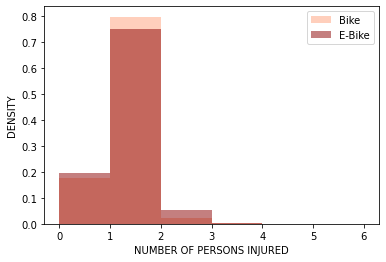

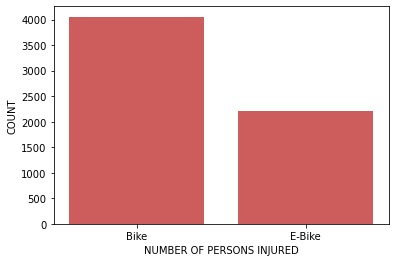

NUMBER OF CYCLIST INJURED Welch's t-test p-value: 0.0


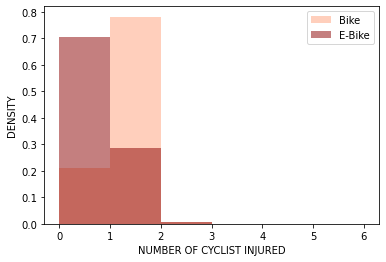

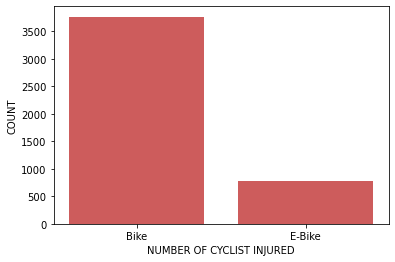

In [9]:
#Persons Injured and Cyclists Injured
#Calculate Welch t-test p-values, plot histograms, plot bar graphs
columns_injured = ['NUMBER OF PERSONS INJURED','NUMBER OF CYCLIST INJURED']
for col in columns:
    #Extract column for bikes and for e-bikes
    bikes_extract = bikes[col]
    ebikes_extract = ebikes[col]

    #Get values from dataframe and cast as numeric
    column_bike = pd.to_numeric(bikes_extract, errors='coerce').values
    column_ebike = pd.to_numeric(ebikes_extract, errors='coerce').values

    #Welch's t-test (cannot assume equal variance due to unequal group size)
    p = stats.ttest_ind(column_bike,column_ebike, equal_var=False)
    print(str(col)+" Welch's t-test p-value: "+str(p[1]))

    #Plot histogram and bar graphs 
    plt.hist(column_bike, bins=[0.0,1.0,2.0,3.0,4.0,5.0,6.0], label="Bike", alpha=0.5, density=True, color ='lightsalmon')
    plt.hist(column_ebike, bins=[0.0,1.0,2.0,3.0,4.0,5.0,6.0], label="E-Bike",alpha=0.5, density=True, color = 'darkred')
    #plt.xticks(ticks, ticklabels)
    plt.xlabel(col)
    plt.ylabel("DENSITY")
    plt.legend()
    plt.show()
    plt.bar(["Bike","E-Bike"], [column_bike.sum(),column_ebike.sum()], color ='indianred')
    plt.xlabel(col)
    plt.ylabel("COUNT")
    plt.show()

NUMBER OF PERSONS KILLED Welch's t-test p-value: 0.005328408716739479


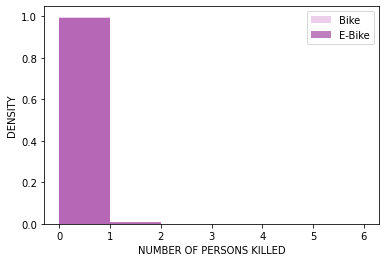

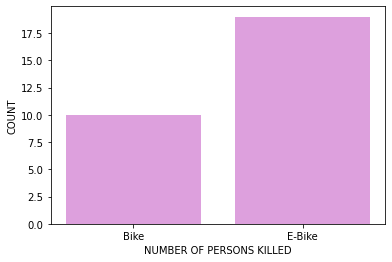

NUMBER OF CYCLIST KILLED Welch's t-test p-value: 0.6116547798822987


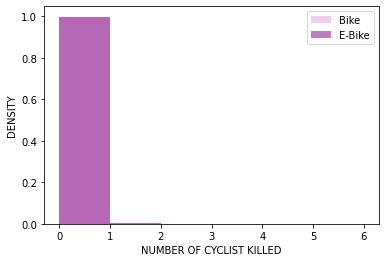

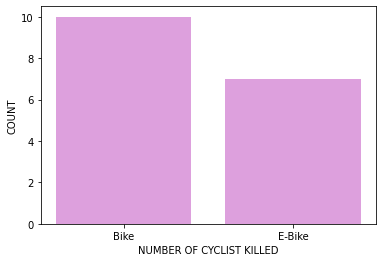

In [10]:
#Persons Killed and Cyclists Killed
#Calculate Welch t-test p-values, plot histograms, plot bar graphs
columns_killed = ['NUMBER OF PERSONS KILLED','NUMBER OF CYCLIST KILLED']
for col in columns_killed:
    #Extract column for bikes and for e-bikes
    bikes_extract = bikes[col]
    ebikes_extract = ebikes[col]

    #Get values from dataframe and cast as numeric
    column_bike = pd.to_numeric(bikes_extract, errors='coerce').values
    column_ebike = pd.to_numeric(ebikes_extract, errors='coerce').values

    #Welch's t-test (cannot assume equal variance due to unequal group size)
    p = stats.ttest_ind(column_bike,column_ebike, equal_var=False)
    print(str(col)+" Welch's t-test p-value: "+str(p[1]))

    #Plot histogram and bar graphs 
    plt.hist(column_bike, bins=[0.0,1.0,2.0,3.0,4.0,5.0,6.0], label="Bike", alpha=0.5, density=True, color ='plum')
    plt.hist(column_ebike, bins=[0.0,1.0,2.0,3.0,4.0,5.0,6.0], label="E-Bike",alpha=0.5, density=True, color = 'purple')
    #plt.xticks(ticks, ticklabels)
    plt.xlabel(col)
    plt.ylabel("DENSITY")
    plt.legend()
    plt.show()
    plt.bar(["Bike","E-Bike"], [column_bike.sum(),column_ebike.sum()], color ='plum')
    plt.xlabel(col)
    plt.ylabel("COUNT")
    plt.show()

In [ ]:
#Need to install imbalanced learn in order to perform the next chunk
#conda install -c conda-forge imbalanced-learn

In [12]:
#Bootstrapping/Under-Over Randomized Sampling to Balance Bike and E-Bike Data

#When we under and over sample, how many times are bike injuries/deaths significantly different than e-bike injuries/deaths? 
#What percentage of bike injuries/deaths are significantly different than e-bike injuries/deaths? 

#Loop through columns (persons injured, persons killed, cyclists injured, cyclists killed)
columns = ['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED']
for col in columns:
    #Initiate statistical significance counters 
    undersample_count = 0
    oversample_count = 0
    #Run 1000 trials 
    for i in range(1000):
        #Create a new dataframe for bike data which includes a column classifying the data as "Bike"
        df_bike_data = pd.DataFrame(bikes[col], columns=[col])
        df_bike_data['Class'] = 'Bike'
        #Create a new dataframe for e-bike data with includes a column classifying the data as "E-Bike"
        df_ebike_data = pd.DataFrame(ebikes[col], columns=[col])
        df_ebike_data['Class'] = 'E-Bike'
        #Concatenate the two dataframes 
        df_combined = pd.concat([df_bike_data, df_ebike_data])
        
        #Cast as a numpy array and reshape array in order to use RandomUnder/OverSampler
        X = np.array(df_combined[col]).reshape(-1,1)
        Y = np.array(df_combined['Class']).reshape(-1,1)

        #Undersample (shrink larger class randomly)
        #Takes the majority class (Bike) and cuts it down to the size of the minority class (E-Bike) by random selection
        #RandomUnderSampler takes argument random_state: 
        #If None, the random number generator is the RandomState instance used by np.random
        undersample = RandomUnderSampler(sampling_strategy='not minority')
        #Get the new even samples (X_res_u is data, Y_res_u is class)
        X_res_u, Y_res_u = undersample.fit_resample(X, Y)

        #Create a new dataframe for the new undersampled data
        undersampled_df = pd.DataFrame(X_res_u,columns=[col])
        #Add a column for class 
        undersampled_df['Class'] = Y_res_u
        #Split the data frame into Bikes and E-Bikes and cast the values as an array for testing
        test_bike_under = undersampled_df[undersampled_df["Class"]=="Bike"][col]
        test_ebike_under = undersampled_df[undersampled_df["Class"]=="E-Bike"][col]
        test_column_bike_under = pd.to_numeric(test_bike_under, errors='coerce').values
        test_column_ebike_under = pd.to_numeric(test_ebike_under, errors='coerce').values
        #Perform independent t-test between bikes and e-bikes (groups now have equal sizes so we can assume equal variance)
        p_val_under = stats.ttest_ind(test_column_bike_under,test_column_ebike_under)
        #If the result is statistically significant add to the count 
        if p_val_under[1] < 0.05:
            undersample_count += 1

        #Oversample (expand smaller class randomly)
        #Takes the minority class (E-Bike) and expands it to the size of the majority class (Bike) by random selection
        #RandomOverSampler takes argument random_state: 
        #If None, the random number generator is the RandomState instance used by np.random
        oversample = RandomOverSampler(sampling_strategy='not majority')
        #Get the new even samples (X_res_u is data, Y_res_u is class)
        X_res_o, Y_res_o = oversample.fit_resample(X, Y)

        #Create a new dataframe for the new oversampled data
        oversampled_df = pd.DataFrame(X_res_o,columns=[col])
        #Add a column for class
        oversampled_df['Class'] = Y_res_o
        #Split the data frame into Bikes and E-Bikes and cast the values as an array for testing
        test_bike_over = oversampled_df[oversampled_df["Class"]=="Bike"][col]
        test_ebike_over = oversampled_df[oversampled_df["Class"]=="E-Bike"][col]
        test_column_bike_over = pd.to_numeric(test_bike_over, errors='coerce').values
        test_column_ebike_over = pd.to_numeric(test_ebike_over, errors='coerce').values
        #Perform independent t-test between bikes and e-bikes (groups now have equal sizes so we can assume equal variance)
        p_val_over = stats.ttest_ind(test_column_bike_over,test_column_ebike_over)
        #If the result is statistically significant add to the count
        if p_val_over[1] < 0.05:
            oversample_count += 1

    print(str(col)+":")
    print("Undersample count: "+str(undersample_count))
    print("Undersample significance ratio: "+str(undersample_count/1000))
    print("Oversample count: "+str(oversample_count))
    print("Oversample significance ratio: "+str(oversample_count/1000))
print("100% of the time there is a significant difference between cyclist injuries for bikes and e-bikes involved in motor vehicle collisions.")
print("Bikes tend to be significantly more 'dangerous' - categorized as having more cyclist injuries per crash - than e-bikes.")
print("Most of the time there is a significant difference between total people killed for bikes versus e-bikes.")
print("E-Bikes tend to be more 'dangerous' - categorized as more total deaths occurring when one is involved in a crash - than bikes.")

NUMBER OF PERSONS INJURED:
Undersample count: 3
Undersample significance ratio: 0.003
Oversample count: 16
Oversample significance ratio: 0.016
NUMBER OF PERSONS KILLED:
Undersample count: 981
Undersample significance ratio: 0.981
Oversample count: 1000
Oversample significance ratio: 1.0
NUMBER OF CYCLIST INJURED:
Undersample count: 1000
Undersample significance ratio: 1.0
Oversample count: 1000
Oversample significance ratio: 1.0
NUMBER OF CYCLIST KILLED:
Undersample count: 7
Undersample significance ratio: 0.007
Oversample count: 2
Oversample significance ratio: 0.002
100% of the time there is a significant difference between cyclist injuries for bikes and e-bikes involved in motor vehicle collisions.
Bikes tend to be significantly more 'dangerous' - categorized as having more cyclist injuries per crash - than e-bikes.
Most of the time there is a significant difference between total people killed for bikes versus e-bikes.
E-Bikes tend to be more 'dangerous' - categorized as more total

# Question 4: What were the most dangerous times of year/week/day?

In [2]:
#Load data
time_df = pd.read_csv('clean_all_with_zips_buroughs_final_version.csv')

#Create a crash datetime column
crash_datetime = time_df['CRASH DATE'] + ' ' + time_df['CRASH TIME']

#Insert crash datetime into first column position
time_df.insert(0,'CRASH DATETIME',crash_datetime)

#Drop columns not being used for time series analysis
time_df = time_df.drop(time_df.columns[[1,2,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=False)

#Convert crash datetime to pandas datetime object 
time_df['CRASH DATETIME'] = pd.to_datetime(time_df['CRASH DATETIME'])

#Check for null values
# print(time_df.isnull().sum())

#Impute 0 for null values
time_df = time_df.fillna(0)
# display(time_df[time_df['NUMBER OF PERSONS INJURED'].isnull()])

#Convert counts to type int
time_df['NUMBER OF PERSONS INJURED'] = time_df['NUMBER OF PERSONS INJURED'].astype('int64')
time_df['NUMBER OF PERSONS KILLED'] = time_df['NUMBER OF PERSONS KILLED'].astype('int64')

# display(time_df)

In [3]:
# Convert time_df datetime to index
cdt_df = time_df.set_index('CRASH DATETIME')
cdt_df['NUMBER OF ACCIDENTS'] = 1
# display(cdt_df)

# Time of Day (Every Hour) 
sum_hour = cdt_df.groupby(cdt_df.index.hour).sum()
# display(sum_time)

# Day of the Week
dow = ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
sum_dow = cdt_df.groupby(cdt_df.index.weekday).sum()
sum_dow.index = dow
# display(sum_dow)

# Month
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sum_month = cdt_df.groupby(cdt_df.index.month).sum()
sum_month.index = month
# display(sum_month)

# Season
sum_fall = pd.DataFrame(sum_month.iloc[8:11,:].sum()).transpose()
sum_fall.index = ['Fall']
sum_winter = pd.DataFrame(sum_month.iloc[[11,0,1],:].sum()).transpose()
sum_winter.index = ['Winter']
sum_spring = pd.DataFrame(sum_month.iloc[2:5,:].sum()).transpose()
sum_spring.index = ['Spring']
sum_summer = pd.DataFrame(sum_month.iloc[5:8,:].sum()).transpose()
sum_summer.index = ['Summer']
sum_frames = [sum_fall,sum_winter,sum_spring,sum_summer]
sum_season = pd.concat(sum_frames)
# display(sum_season)

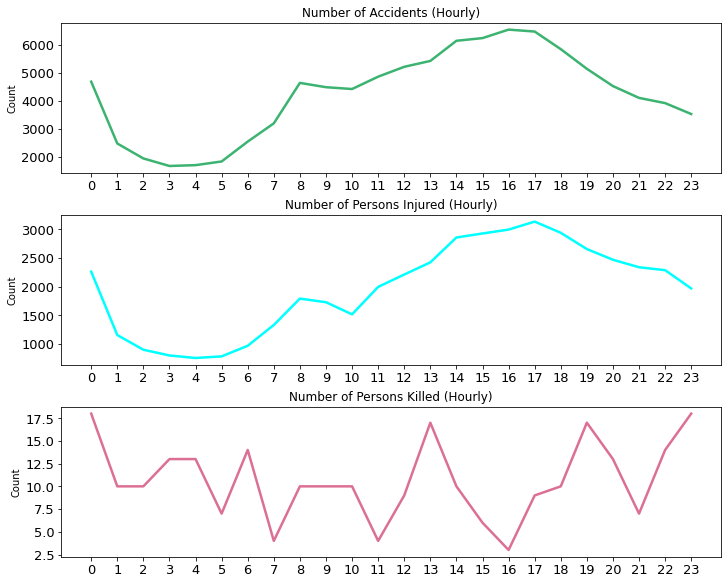

In [4]:
# Time of Day (Every Hour) - Visualization
ticks = np.arange(0, 24, step=1)
fig = plt.figure(figsize=(10,8), constrained_layout=True)
plt.subplot(3,1,1)
sum_hour['NUMBER OF ACCIDENTS'].plot(linewidth=2.5, color='mediumseagreen', xticks=ticks, xlabel='', ylabel='Count', title='Number of Accidents (Hourly)', fontsize=13);
plt.subplot(3,1,2)
sum_hour['NUMBER OF PERSONS INJURED'].plot(linewidth=2.5, color='cyan', xticks=ticks, xlabel='', ylabel='Count', title='Number of Persons Injured (Hourly)', fontsize=13);
plt.subplot(3,1,3)
sum_hour['NUMBER OF PERSONS KILLED'].plot(linewidth=2.5, color='palevioletred', xticks=ticks, xlabel='', ylabel='Count', title='Number of Persons Killed (Hourly)', fontsize=13);

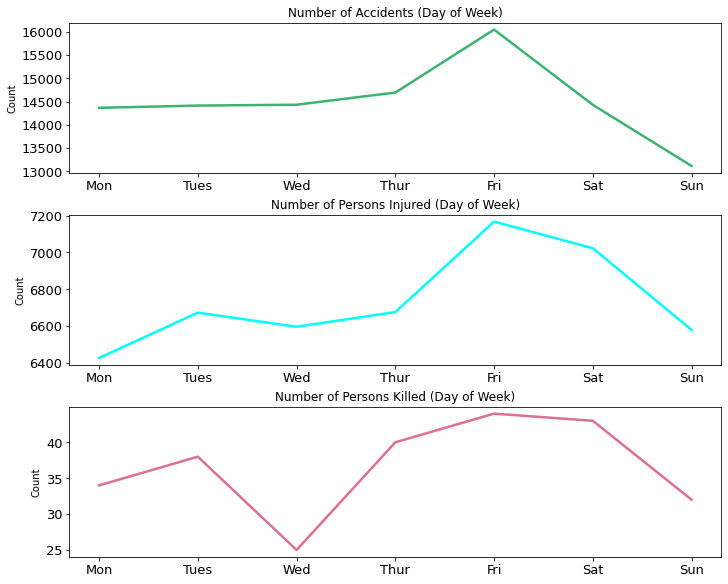

In [5]:
# Day of the Week - Visualization
fig = plt.figure(figsize=(10,8), constrained_layout=True)
plt.subplot(3,1,1)
sum_dow['NUMBER OF ACCIDENTS'].plot(linewidth=2.5, color='mediumseagreen', ylabel='Count', title='Number of Accidents (Day of Week)', fontsize=13);
plt.subplot(3,1,2)
sum_dow['NUMBER OF PERSONS INJURED'].plot(linewidth=2.5, color='cyan', ylabel='Count', title='Number of Persons Injured (Day of Week)', fontsize=13);
plt.subplot(3,1,3)
sum_dow['NUMBER OF PERSONS KILLED'].plot(linewidth=2.5, color='palevioletred', ylabel='Count', title='Number of Persons Killed (Day of Week)', fontsize=13);

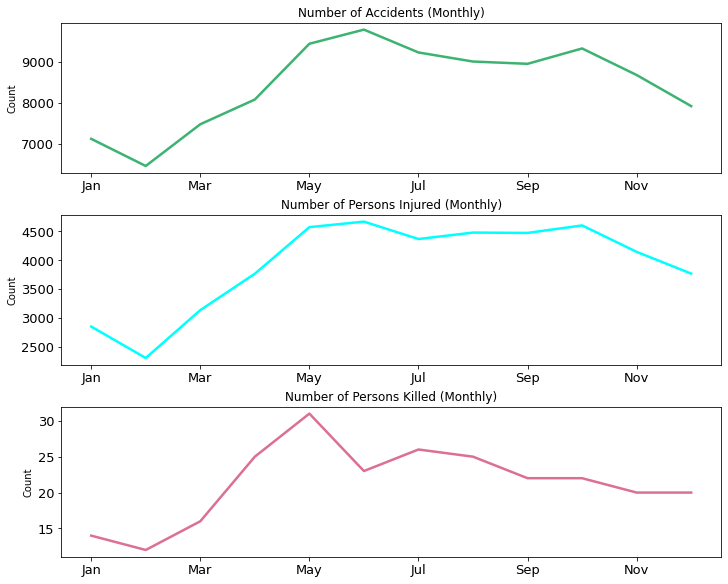

In [6]:
# Month - Visualization
fig = plt.figure(figsize=(10,8), constrained_layout=True)
plt.subplot(3,1,1)
sum_month['NUMBER OF ACCIDENTS'].plot(linewidth=2.5, color='mediumseagreen', ylabel='Count', title='Number of Accidents (Monthly)', fontsize=13);
plt.subplot(3,1,2)
sum_month['NUMBER OF PERSONS INJURED'].plot(linewidth=2.5,color='cyan', ylabel='Count', title='Number of Persons Injured (Monthly)', fontsize=13);
plt.subplot(3,1,3)
sum_month['NUMBER OF PERSONS KILLED'].plot(linewidth=2.5, color='palevioletred', ylabel='Count', title='Number of Persons Killed (Monthly)', fontsize=13);

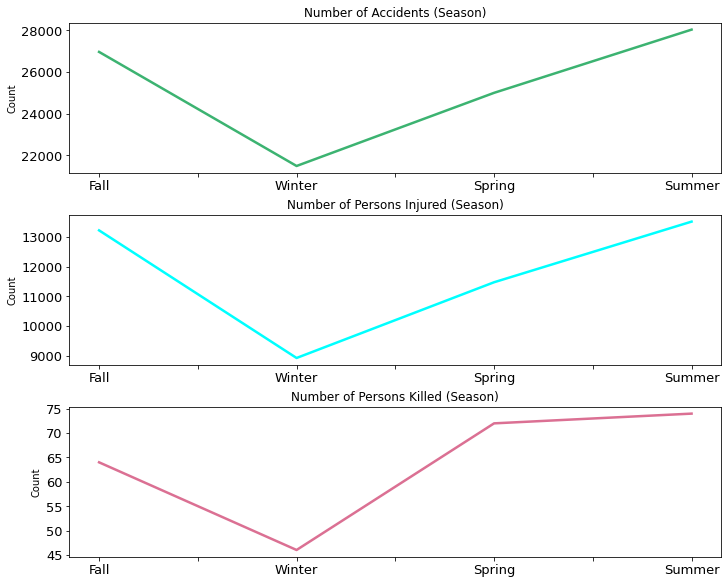

In [7]:
# Season - Visualization
fig = plt.figure(figsize=(10,8), constrained_layout=True)
plt.subplot(3,1,1)
sum_season['NUMBER OF ACCIDENTS'].plot(linewidth=2.5, color='mediumseagreen', ylabel='Count', title='Number of Accidents (Season)', fontsize=13);
plt.subplot(3,1,2)
sum_season['NUMBER OF PERSONS INJURED'].plot(linewidth=2.5,color='cyan', ylabel='Count', title='Number of Persons Injured (Season)', fontsize=13);
plt.subplot(3,1,3)
sum_season['NUMBER OF PERSONS KILLED'].plot(linewidth=2.5, color='palevioletred', ylabel='Count', title='Number of Persons Killed (Season)', fontsize=13);

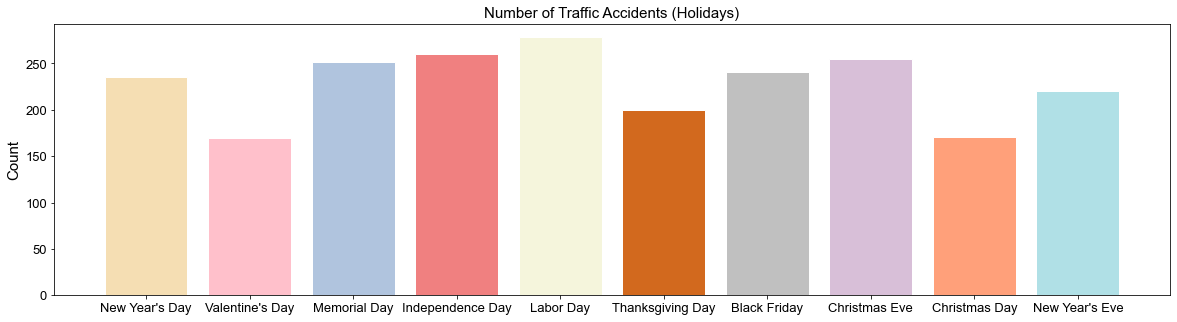

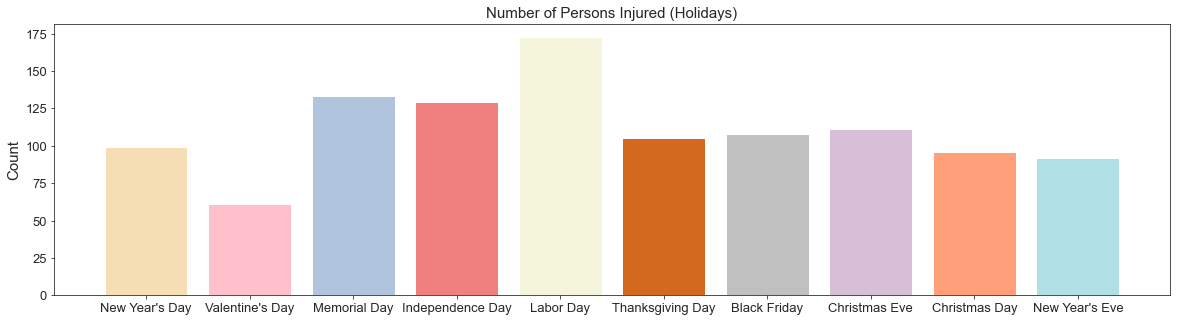

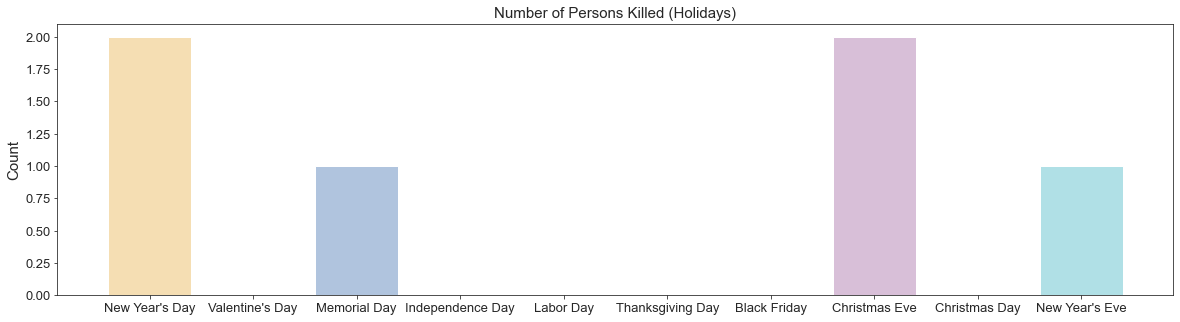

In [8]:
# Holidays - Dataframe and Visualization
day = time_df.groupby(pd.Grouper(key='CRASH DATETIME', freq='1D'))

#Number of occurences per day
occur_day = day.size().reset_index()
occur_day.rename({'CRASH DATETIME':'CRASH DATE', 0: 'NUMBER OF ACCIDENTS'}, axis=1, inplace=True)

#Persons Injured/Killed per day
persons_day = day.sum().reset_index()
persons_day.rename({'CRASH DATETIME':'CRASH DATE'}, axis=1, inplace=True)

#Merge dataframes
crash_day = pd.merge(occur_day, persons_day)
#display(crash_day)

#New Year's Day
NYD = (crash_day[crash_day['CRASH DATE']=='2021-01-01']).reset_index(drop=True)
NYD = NYD.replace({'2021-01-01':"New Year's Day"})

#Valentine's Day
VD = (crash_day[crash_day['CRASH DATE']=='2021-02-14']).reset_index(drop=True)
VD = VD.replace({'2021-02-14':"Valentine's Day"})

#Memorial Day
MD = (crash_day[crash_day['CRASH DATE']=='2021-05-31']).reset_index(drop=True)
MD = MD.replace({'2021-05-31':"Memorial Day"})

#Independence Day
ID = (crash_day[crash_day['CRASH DATE']=='2021-07-04']).reset_index(drop=True)
ID = ID.replace({'2021-07-04':"Independence Day"})

#Labor Day
LD = (crash_day[crash_day['CRASH DATE']=='2021-09-06']).reset_index(drop=True)
LD = LD.replace({'2021-09-06':"Labor Day"})

#Thanksgiving Day
TD = (crash_day[crash_day['CRASH DATE']=='2021-11-25']).reset_index(drop=True)
TD = TD.replace({'2021-11-25':"Thanksgiving Day"})

#Black Friday
BF = (crash_day[crash_day['CRASH DATE']=='2021-11-26']).reset_index(drop=True)
BF = BF.replace({'2021-11-26':"Black Friday"})

#Christmas Eve
CE = (crash_day[crash_day['CRASH DATE']=='2021-12-24']).reset_index(drop=True)
CE = CE.replace({'2021-12-24':"Christmas Eve"})

#Christmas Day
CD = (crash_day[crash_day['CRASH DATE']=='2021-12-25']).reset_index(drop=True)
CD = CD.replace({'2021-12-25':"Christmas Day"})

#New Year's Eve
NYE = (crash_day[crash_day['CRASH DATE']=='2021-12-31']).reset_index(drop=True)
NYE = NYE.replace({'2021-12-31':"New Year's Eve"})

#Create Holiday Dataframe
holidays = [NYD, VD, MD, ID, LD, TD, BF, CE, CD, NYE]
holidays_df = pd.concat(holidays)
holidays_df.rename({'CRASH DATE':'HOLIDAY'}, axis=1, inplace=True)
holidays_df = holidays_df.set_index('HOLIDAY')
#display(holidays_df)

#Create Holiday dictionaries
holiday_acc_dict = holidays_df['NUMBER OF ACCIDENTS'].to_dict()
names_acc = list(holiday_acc_dict.keys())
values_acc = list(holiday_acc_dict.values())

holiday_injury_dict = holidays_df['NUMBER OF PERSONS INJURED'].to_dict()
names_injury = list(holiday_injury_dict.keys())
values_injury = list(holiday_injury_dict.values())

holiday_death_dict = holidays_df['NUMBER OF PERSONS KILLED'].to_dict()
names_death = list(holiday_death_dict.keys())
values_death = list(holiday_death_dict.values())

#Visualization - Number of Accidents (Holidays)
colors = ['wheat', 'pink', 'lightsteelblue', 'lightcoral', 'beige', 'chocolate', 'silver', 'thistle', 'lightsalmon', 'powderblue']
f, ax = plt.subplots(figsize = (20,5))
sns.set_style("ticks")
ax.bar(names_acc, values_acc, color=colors)
plt.title('Number of Traffic Accidents (Holidays)', fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel(ylabel='Count', fontsize=15)
plt.yticks(fontsize=13);

#Visualization - Number of Persons Injured (Holidays)
f2, ax = plt.subplots(figsize = (20,5))
sns.set_style("ticks")
ax.bar(names_injury, values_injury, color=colors)
plt.title('Number of Persons Injured (Holidays)', fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel(ylabel='Count', fontsize=15)
plt.yticks(fontsize=13);

#Visualization - Number of Killed (Holidays)
f3, ax = plt.subplots(figsize = (20,5))
sns.set_style("ticks")
ax.bar(names_death, values_death, color=colors)
plt.title('Number of Persons Killed (Holidays)', fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel(ylabel='Count', fontsize=15)
plt.yticks(fontsize=13);

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f5d584d7-8c21-4a43-bee6-b148c3c0a755' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>